Epoch 1/1000
1053/1053 [==============================] - 1s 680us/step - loss: 151646.7656 - val_loss: 118058.3594
Epoch 2/1000
1053/1053 [==============================] - 1s 623us/step - loss: 111852.8594 - val_loss: 100363.8203
Epoch 3/1000
1053/1053 [==============================] - 1s 620us/step - loss: 102469.1641 - val_loss: 91824.4766
Epoch 4/1000
1053/1053 [==============================] - 1s 622us/step - loss: 95480.2266 - val_loss: 86318.4219
Epoch 5/1000
1053/1053 [==============================] - 1s 612us/step - loss: 91535.2109 - val_loss: 83624.7969
Epoch 6/1000
1053/1053 [==============================] - 1s 614us/step - loss: 89062.5312 - val_loss: 81970.3672
Epoch 7/1000
1053/1053 [==============================] - 1s 618us/step - loss: 87293.4609 - val_loss: 80452.3672
Epoch 8/1000
1053/1053 [==============================] - 1s 614us/step - loss: 85335.3672 - val_loss: 79281.5781
Epoch 9/1000
1053/1053 [==============================] - 1s 605us/step - loss: 858

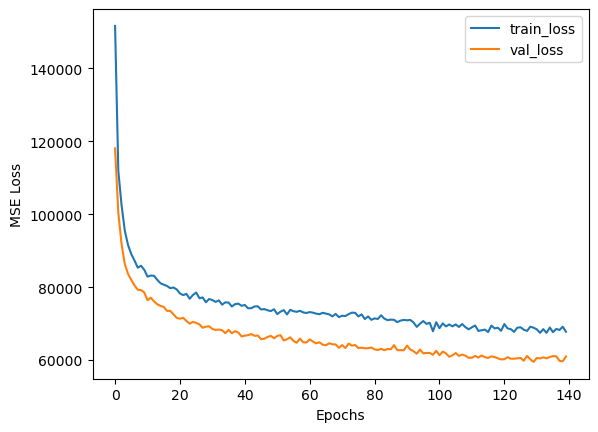

226/226 [==============================] - 0s 432us/step - loss: 60963.7969
Test Loss: 60963.796875
226/226 [==============================] - 0s 376us/step
First 10 Predictions:
 [[ 2.4649734e+01]
 [ 5.4886055e-01]
 [ 2.4649734e+01]
 [ 2.4649734e+01]
 [ 1.3244482e+02]
 [ 2.4649734e+01]
 [-1.1382072e+01]
 [ 4.8133728e+02]
 [ 7.2312720e+02]
 [ 2.3980757e+01]]


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data.drop(['timestamp', 'date'], axis=1, inplace=True)

    data['rpm'] = data['rpm'].fillna(0)

    for col in ['voltage', 'current']:
        data[col] = data[col].fillna(data[col].rolling(window=5, min_periods=1).mean())
        data[col] = data[col].fillna(data[col].rolling(window=5, min_periods=1).mean().shift(-4))
    
    data.dropna(inplace=True)
    
    return data

def split_and_scale_data(data):
    X = data.drop('rpm', axis=1)
    y = data['rpm']
    
    scaler = StandardScaler()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train = scaler.fit_transform(X_train)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_model(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    return model

def plot_training_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

# Main function
data_path = '..\Data\MergedData.csv'
data = load_and_preprocess_data(data_path)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_data(data)

model = create_model(X_train.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

plot_training_history(history)

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test)
print("First 10 Predictions:\n", predictions[:10])
